
# Exercise 3.3 – Femoral Implant Segmentation via Thresholding + ROC (Python)

This notebook mirrors the MATLAB workflow using **NumPy + Matplotlib**.  
It loads an x‑ray image and a binary ground truth (GT) mask, performs **threshold-based segmentation**, computes **TP/TN/FP/FN**, sweeps thresholds to build **ROC/Dice/IoU** curves, and selects an **optimal threshold** (Youden's *J* and Dice).

> Data used here were split from the provided triptych (x‑ray | ground truth | example threshold).  
> If you have your own images, set `XRAY_PATH` and `GT_PATH` accordingly.


In [2]:

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

%matplotlib inline

XRAY_PATH = "postop_xray.png"
GT_PATH   = "groundtruth_mask.png"

def load_grayscale(path):
    img = Image.open(path).convert("L")
    arr = np.array(img)
    return arr

def show_side_by_side(imgs, titles=None, figsize=(12,4)):
    n = len(imgs)
    plt.figure(figsize=figsize)
    for i, im in enumerate(imgs, 1):
        ax = plt.subplot(1, n, i)
        if im.ndim == 2:
            ax.imshow(im, cmap="gray")
        else:
            ax.imshow(im)
        ax.set_axis_off()
        if titles:
            ax.set_title(titles[i-1])
    plt.show()

def threshold_image(I, T):
    """Return binary image: 1 where I > T, else 0."""
    return (I > T).astype(np.uint8)

def calc_stats(GT, TEST):
    """Return TP, TN, FP, FN comparing binary arrays (0/1)."""
    GTb   = (GT > 0)
    TESTb = (TEST > 0)
    TP = np.sum(TESTb & GTb)
    TN = np.sum(~TESTb & ~GTb)
    FP = np.sum(TESTb & ~GTb)
    FN = np.sum(~TESTb & GTb)
    return int(TP), int(TN), int(FP), int(FN)

def dice_score(TP, FP, FN):
    denom = (2*TP + FP + FN)
    return (2*TP / denom) if denom else 0.0

def iou_score(TP, FP, FN):
    denom = (TP + FP + FN)
    return (TP / denom) if denom else 0.0

def otsu_threshold(I):
    """Compute Otsu's global threshold for 8-bit image."""
    hist = np.bincount(I.ravel(), minlength=256).astype(np.float64)
    total = I.size
    prob = hist / total
    omega = np.cumsum(prob)
    mu = np.cumsum(prob * np.arange(256))
    mu_t = mu[-1]

    sigma_b2 = (mu_t*omega - mu)**2 / (omega * (1.0 - omega) + 1e-12)
    sigma_b2[:1] = 0.0
    sigma_b2[-1:] = 0.0
    return int(np.argmax(sigma_b2))


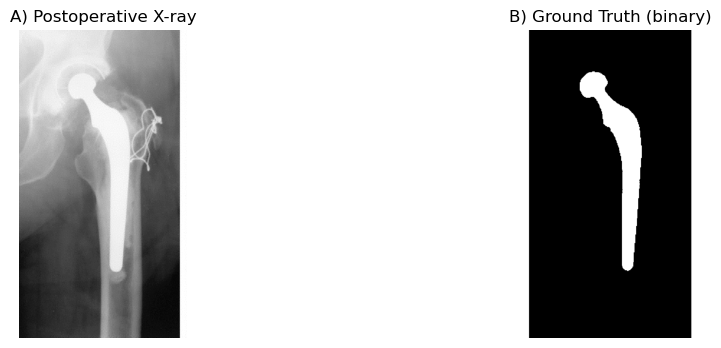

Image shapes: (759, 414) (759, 414)


In [3]:

# Load images (these two files are included alongside the notebook)
xray = load_grayscale("postop_xray.png")
gt   = load_grayscale("groundtruth_mask.png")

# Binarize GT robustly (white implant on black background in the provided GT panel)
gt_bin = (gt > 128).astype(np.uint8)

show_side_by_side([xray, gt_bin*255], ["A) Postoperative X-ray", "B) Ground Truth (binary)"])
print("Image shapes:", xray.shape, gt_bin.shape)


Threshold T=180
TP=29636, TN=217923, FP=62051, FN=4616
Sens/TPR=0.865, FPR=0.222, ACC=0.788, Dice=0.471, IoU=0.308


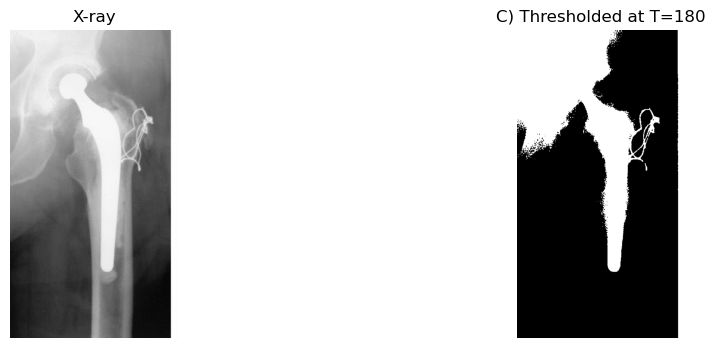

In [4]:

# Demo: choose a threshold and visualize the segmentation
T = 180  # try changing this and re-running
seg = threshold_image(xray, T)

TP, TN, FP, FN = calc_stats(gt_bin, seg)
P = TP + FN
N = TN + FP
TPR = TP / max(P, 1)    # sensitivity/recall
FPR = FP / max(N, 1)    # 1 - specificity
ACC = (TP + TN) / max(P+N, 1)
DICE = dice_score(TP, FP, FN)
IOU  = iou_score(TP, FP, FN)

print(f"Threshold T={T}")
print(f"TP={TP}, TN={TN}, FP={FP}, FN={FN}")
print(f"Sens/TPR={TPR:.3f}, FPR={FPR:.3f}, ACC={ACC:.3f}, Dice={DICE:.3f}, IoU={IOU:.3f}")

show_side_by_side([xray, seg*255], ["X-ray", f"C) Thresholded at T={T}"])


In [5]:

# Sweep thresholds 0..255 and compute metrics
thresh_vals = np.arange(256, dtype=int)
TPR = np.zeros_like(thresh_vals, dtype=float)
FPR = np.zeros_like(thresh_vals, dtype=float)
ACC = np.zeros_like(thresh_vals, dtype=float)
DICE = np.zeros_like(thresh_vals, dtype=float)
IOU  = np.zeros_like(thresh_vals, dtype=float)

for k, T in enumerate(thresh_vals):
    seg = threshold_image(xray, T)
    TP, TN, FP, FN = calc_stats(gt_bin, seg)

    P = TP + FN
    N = TN + FP
    TPR[k] = TP / max(P, 1)
    FPR[k] = FP / max(N, 1)
    ACC[k] = (TP + TN) / max(P+N, 1)
    DICE[k]= dice_score(TP, FP, FN)
    IOU[k] = iou_score(TP, FP, FN)

# Optimal thresholds
J = TPR - FPR
Topt_J = thresh_vals[np.argmax(J)]
Topt_D = thresh_vals[np.argmax(DICE)]
T_otsu = otsu_threshold(xray)

print(f"Optimal by Youden J: T={Topt_J} "
      f"(TPR={TPR[Topt_J]:.3f}, FPR={FPR[Topt_J]:.3f}, ACC={ACC[Topt_J]:.3f}, "
      f"Dice={DICE[Topt_J]:.3f}, IoU={IOU[Topt_J]:.3f})")
print(f"Optimal by Dice:     T={Topt_D} "
      f"(TPR={TPR[Topt_D]:.3f}, FPR={FPR[Topt_D]:.3f}, ACC={ACC[Topt_D]:.3f}, "
      f"Dice={DICE[Topt_D]:.3f}, IoU={IOU[Topt_D]:.3f})")
print(f"Otsu's threshold:    T={T_otsu}")


Optimal by Youden J: T=232 (TPR=0.737, FPR=0.074, ACC=0.906, Dice=0.630, IoU=0.460)
Optimal by Dice:     T=238 (TPR=0.670, FPR=0.042, ACC=0.926, Dice=0.665, IoU=0.498)
Otsu's threshold:    T=135


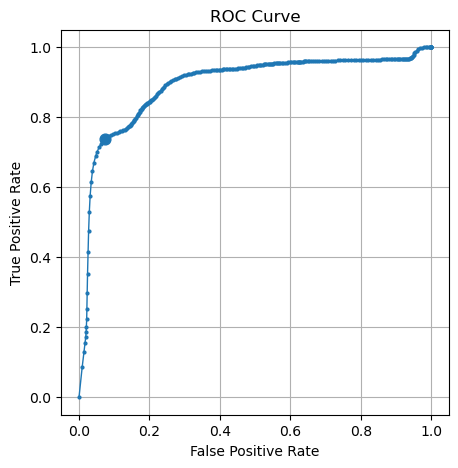

In [6]:

plt.figure(figsize=(5,5))
plt.plot(FPR, TPR, marker='o', markersize=2, linewidth=1)
plt.scatter(FPR[np.argmax(TPR - FPR)], TPR[np.argmax(TPR - FPR)], s=60)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.grid(True)
plt.show()


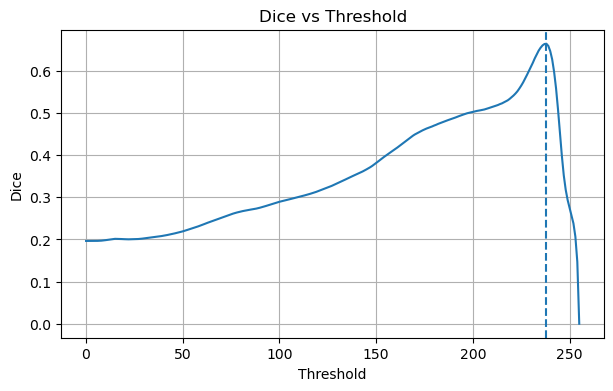

In [7]:

plt.figure(figsize=(7,4))
plt.plot(thresh_vals, DICE, linewidth=1.5)
plt.axvline(thresh_vals[np.argmax(DICE)], linestyle='--')
plt.xlabel("Threshold")
plt.ylabel("Dice")
plt.title("Dice vs Threshold")
plt.grid(True)
plt.show()


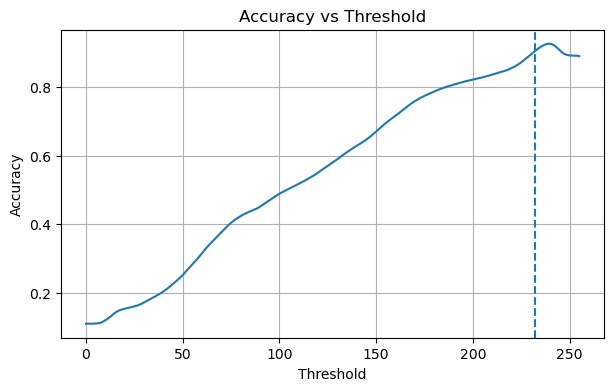

In [8]:

plt.figure(figsize=(7,4))
plt.plot(thresh_vals, ACC, linewidth=1.5)
plt.axvline(thresh_vals[np.argmax(TPR - FPR)], linestyle='--')
plt.xlabel("Threshold")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Threshold")
plt.grid(True)
plt.show()


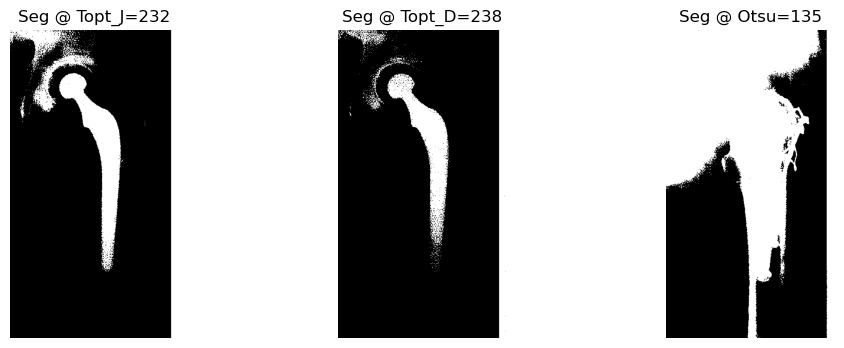

In [16]:

# Visualize masks at chosen thresholds
Topt_J = int(thresh_vals[np.argmax(TPR - FPR)])
Topt_D = int(thresh_vals[np.argmax(DICE)])

def _seg(T):
    return threshold_image(xray, int(T))*255

show_side_by_side([_seg(Topt_J), _seg(Topt_D), _seg(otsu_threshold(xray))],
                  [f"Seg @ Topt_J={Topt_J}",
                   f"Seg @ Topt_D={Topt_D}",
                   f"Seg @ Otsu={int(otsu_threshold(xray))}"])



## (Optional) Interactive threshold slider

If you have `ipywidgets` installed, run the cell below for an interactive view.


In [19]:

try:
    from ipywidgets import interact, IntSlider
    def demo(T=180):
        seg = threshold_image(xray, T)
        show_side_by_side([xray, seg*255], ["X-ray", f"Thresholded T={T}"])
    interact(demo, T=IntSlider(min=0, max=255, step=1, value=180));
except Exception as e:
    print("ipywidgets not available. You can install it in your environment to enable the slider.")
    print(e)


interactive(children=(IntSlider(value=180, description='T', max=255), Output()), _dom_classes=('widget-interac…


# Exercises 3.4 & 3.5 — Se/Sp across thresholds, ROC, and Youden index

This section mirrors the MATLAB tasks using Python:
1. Compute **Sensitivity (Se)** and **Specificity (Sp)** for multiple thresholds.  
2. Sweep thresholds from the **min to the max** intensity in the x‑ray.  
3. Store Se/Sp across thresholds and **plot an ROC** (Se vs 1−Sp).  
4. Implement `calculate_youden_index(Se, Sp)` and find the **optimal threshold** (max *J* = Se + Sp − 1).


In [22]:

def calc_se_sp(TP, TN, FP, FN):
    """Return (Se, Sp) given confusion counts."""
    P = TP + FN
    N = TN + FP
    Se = TP / P if P else 0.0
    Sp = TN / N if N else 0.0
    return Se, Sp

def calculate_youden_index(Se_arr, Sp_arr):
    """Return (J, idx_opt) where J = Se + Sp - 1, idx_opt = argmax J."""
    Se_arr = np.asarray(Se_arr, dtype=float)
    Sp_arr = np.asarray(Sp_arr, dtype=float)
    J = Se_arr + Sp_arr - 1.0
    idx_opt = int(np.nanargmax(J))
    return J, idx_opt


T   |   Se    Sp    TP    TN    FP    FN
140 | 0.936 0.592   32076 165626 114348   2176
160 | 0.922 0.692   31593 193671  86303   2659
180 | 0.865 0.778   29636 217923  62051   4616
200 | 0.824 0.822   28226 230233  49741   6026


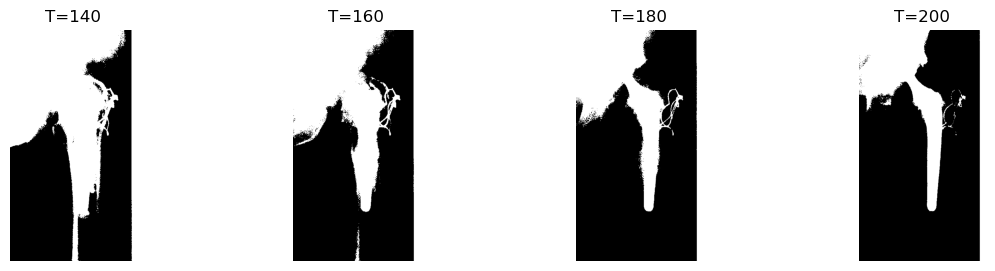

In [24]:

# -- Try a few thresholds (edit the list as you like) --
trial_thresholds = [140, 160, 180, 200]

rows = []
for T in trial_thresholds:
    seg = threshold_image(xray, T)
    TP, TN, FP, FN = calc_stats(gt_bin, seg)
    Se, Sp = calc_se_sp(TP, TN, FP, FN)
    rows.append((T, Se, Sp, TP, TN, FP, FN))

print("T   |   Se    Sp    TP    TN    FP    FN")
for r in rows:
    print(f"{r[0]:3d} | {r[1]:.3f} {r[2]:.3f}  {r[3]:6d} {r[4]:6d} {r[5]:6d} {r[6]:6d}")

# Show segmentations for quick visual comparison
segs = [threshold_image(xray, T)*255 for T in trial_thresholds]
titles = [f"T={T}" for T in trial_thresholds]
show_side_by_side(segs, titles, figsize=(14,3))


In [25]:

Imin, Imax = int(xray.min()), int(xray.max())
thresholds = np.arange(Imin, Imax+1, dtype=int)

Se_arr = np.zeros_like(thresholds, dtype=float)
Sp_arr = np.zeros_like(thresholds, dtype=float)

for k, T in enumerate(thresholds):
    seg = threshold_image(xray, int(T))
    TP, TN, FP, FN = calc_stats(gt_bin, seg)
    Se, Sp = calc_se_sp(TP, TN, FP, FN)
    Se_arr[k] = Se
    Sp_arr[k] = Sp

print(f"Threshold sweep from {Imin} to {Imax} inclusive. {len(thresholds)} thresholds evaluated.")


Threshold sweep from 1 to 255 inclusive. 255 thresholds evaluated.


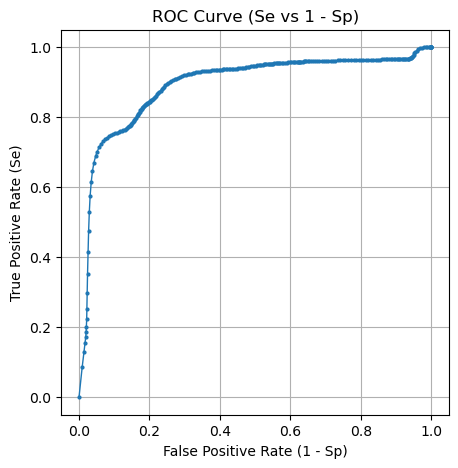

In [28]:

FPR_arr = 1.0 - Sp_arr
TPR_arr = Se_arr

plt.figure(figsize=(5,5))
plt.plot(FPR_arr, TPR_arr, marker='o', markersize=2, linewidth=1)
plt.xlabel("False Positive Rate (1 - Sp)")
plt.ylabel("True Positive Rate (Se)")
plt.title("ROC Curve (Se vs 1 - Sp)")
plt.grid(True)
plt.show()


Optimal threshold by Youden's J: T=232
Se=0.737, Sp=0.926, J=0.663


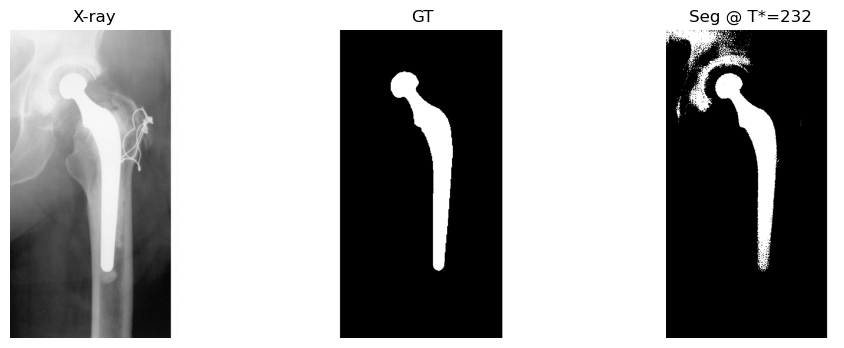

In [30]:

J, idx_opt = calculate_youden_index(Se_arr, Sp_arr)
T_opt = int(thresholds[idx_opt])
Se_opt = Se_arr[idx_opt]
Sp_opt = Sp_arr[idx_opt]

print(f"Optimal threshold by Youden's J: T={T_opt}")
print(f"Se={Se_opt:.3f}, Sp={Sp_opt:.3f}, J={J[idx_opt]:.3f}")

# Visualize segmentation at T_opt
seg_opt = threshold_image(xray, T_opt)*255
show_side_by_side([xray, gt_bin*255, seg_opt], ["X-ray", "GT", f"Seg @ T*={T_opt}"])



## AUC and Precision–Recall Curve

Here we compute:
- **ROC AUC** two ways: (1) trapezoidal integration of the ROC points, (2) directly from raw pixel scores (intensity) if `scikit-learn` is available.
- **Precision–Recall (PR) curve** and **Average Precision (AP)**. The PR curve is often more informative when the positive class is rare.


AUC (ROC, trapezoid over sweep) = 0.8923
AUC (from raw scores) = 0.8923
Average Precision (from raw scores) = 0.5350


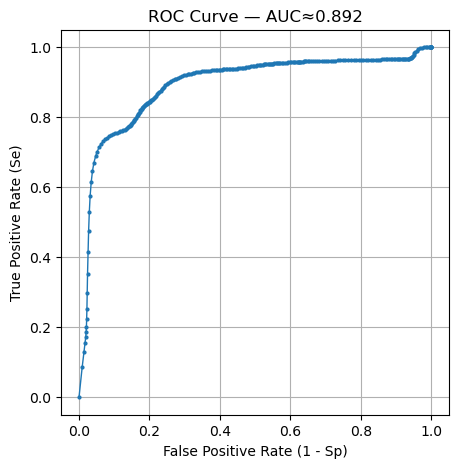

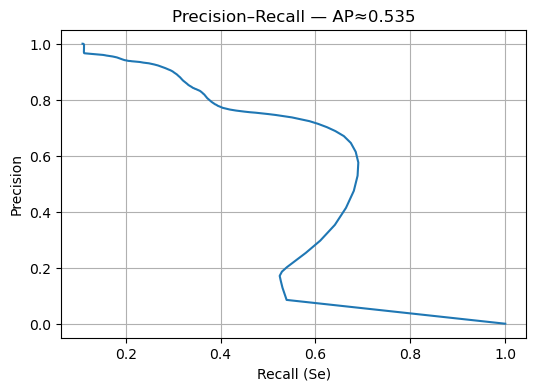

In [33]:

import numpy as np
import matplotlib.pyplot as plt

# We already have: thresholds, Se_arr (TPR), Sp_arr
FPR_arr = 1.0 - Sp_arr
TPR_arr = Se_arr

# --- ROC AUC via trapezoidal rule over swept thresholds ---
order = np.argsort(FPR_arr)
AUC_trapz = np.trapz(TPR_arr[order], FPR_arr[order])
print(f"AUC (ROC, trapezoid over sweep) = {AUC_trapz:.4f}")

# --- Optional: AUC and PR via scikit-learn (raw scores) ---
precision = recall = None
AP_sk = None
AUC_raw = None

try:
    from sklearn.metrics import roc_auc_score, precision_recall_curve, average_precision_score
    y_true   = gt_bin.ravel().astype(int)     # 1=implant, 0=background
    y_scores = xray.ravel().astype(float)     # intensity as score
    AUC_raw  = roc_auc_score(y_true, y_scores)
    recall, precision, _ = precision_recall_curve(y_true, y_scores)
    AP_sk = average_precision_score(y_true, y_scores)
    print(f"AUC (from raw scores) = {AUC_raw:.4f}")
    print(f"Average Precision (from raw scores) = {AP_sk:.4f}")
except Exception as e:
    print("scikit-learn not available for raw-score metrics; falling back to manual PR from threshold sweep.")
    # --- Manual PR from threshold sweep ---
    prec_arr = np.zeros_like(thresholds, dtype=float)
    rec_arr  = np.zeros_like(thresholds, dtype=float)
    for k, T in enumerate(thresholds):
        seg = threshold_image(xray, int(T))
        TP, TN, FP, FN = calc_stats(gt_bin, seg)
        # Precision = TP / (TP + FP), define as 1.0 when no positive predictions
        denom = (TP + FP)
        prec_arr[k] = (TP / denom) if denom else 1.0
        # Recall = TP / (TP + FN) == Se
        rec_arr[k]  = TP / (TP + FN) if (TP + FN) else 0.0

    # Sort by recall to integrate
    ord2 = np.argsort(rec_arr)
    recall = rec_arr[ord2]
    precision = prec_arr[ord2]
    # Trapezoidal estimate of PR-AUC (note: sklearn's AP uses step-wise interpolation)
    AP_sk = np.trapz(precision, recall)
    print(f"Average Precision (trapz over sweep) = {AP_sk:.4f}")

# --- Plots ---
# ROC with AUC
plt.figure(figsize=(5,5))
plt.plot(FPR_arr[order], TPR_arr[order], marker='o', markersize=2, linewidth=1)
plt.xlabel("False Positive Rate (1 - Sp)")
plt.ylabel("True Positive Rate (Se)")
plt.title(f"ROC Curve — AUC≈{AUC_trapz:.3f}")
plt.grid(True)
plt.show()

# PR curve
if (precision is not None) and (recall is not None):
    plt.figure(figsize=(6,4))
    plt.plot(recall, precision, linewidth=1.5)
    if AP_sk is not None:
        plt.title(f"Precision–Recall — AP≈{AP_sk:.3f}")
    else:
        plt.title("Precision–Recall Curve")
    plt.xlabel("Recall (Se)")
    plt.ylabel("Precision")
    plt.grid(True)
    plt.show()
else:
    print("(PR curve unavailable)")



## Mini EMG‑Onset Simulator (threshold = baseline mean + k·σ)

This cell simulates an EMG signal with two activation bursts. We compute an **envelope** (moving RMS), estimate baseline **mean** and **σ** from a pre‑activation window, and detect onset when the envelope exceeds **τ = μ + k·σ** for at least a minimum duration.

We then sweep **k** over a range to trace out **ROC** and **PR** curves and pick the **Youden‑optimal** threshold.


In [36]:

import numpy as np
import matplotlib.pyplot as plt

# ---------------- Simulate EMG -----------------
rng = np.random.default_rng(42)
fs = 1000              # Hz
Tsec = 10.0            # total duration
N = int(fs*Tsec)
t = np.arange(N)/fs

# Ground-truth activation intervals (seconds)
bursts = [(3.0, 4.2),  # start, end
          (6.0, 6.8)]
gt = np.zeros(N, dtype=np.uint8)
for (s, e) in bursts:
    gt[(t>=s) & (t<e)] = 1

# Raw EMG: baseline noise + higher-variance during bursts
baseline_sd = 0.05
active_sd   = 0.20

emg = rng.normal(0.0, baseline_sd, size=N)
for (s, e) in bursts:
    idx = (t>=s) & (t<e)
    emg[idx] += rng.normal(0.0, active_sd, size=idx.sum())

# ---------------- Envelope (moving RMS) -----------------
def moving_rms(x, win):
    # win in samples; simple centered moving RMS via conv
    w = np.ones(win)/win
    x2 = x**2
    y = np.sqrt(np.convolve(x2, w, mode="same"))
    return y

win_ms = 20
win = max(1, int(fs*win_ms/1000))
env = moving_rms(emg, win)

# ---------------- Baseline stats -----------------
# Use first 2 seconds as baseline
baseline_idx = t < 2.0
mu = float(env[baseline_idx].mean())
sd = float(env[baseline_idx].std(ddof=1))

print(f"Baseline envelope: mu={mu:.4f}, sigma={sd:.4f} (from first 2 s)"")

# ---------------- Duration filter -----------------
def duration_filter(mask, min_len):
    """Keep only True runs with length >= min_len (samples)."""
    m = mask.astype(np.uint8)
    if m.size == 0:
        return mask
    out = np.zeros_like(m, dtype=bool)
    i = 0
    n = m.size
    while i < n:
        if m[i]:
            j = i
            while j < n and m[j]:
                j += 1
            if (j - i) >= min_len:
                out[i:j] = True
            i = j
        else:
            i += 1
    return out

min_dur_ms = 30
min_len = max(1, int(fs*min_dur_ms/1000))

# ---------------- Sweep k and compute metrics -----------------
k_vals = np.linspace(0.5, 5.0, 91)   # 0.5 .. 5.0 step 0.05
Se_arr = np.zeros_like(k_vals)
Sp_arr = np.zeros_like(k_vals)
Pre_arr= np.zeros_like(k_vals)
Rec_arr= np.zeros_like(k_vals)

P = int(gt.sum())
Nneg = int((1-gt).sum())

def confusion(pred, true):
    TP = int(np.sum((pred==1)&(true==1)))
    TN = int(np.sum((pred==0)&(true==0)))
    FP = int(np.sum((pred==1)&(true==0)))
    FN = int(np.sum((pred==0)&(true==1)))
    return TP, TN, FP, FN

for i, k in enumerate(k_vals):
    tau = mu + k*sd
    above = env > tau
    pred = duration_filter(above, min_len).astype(np.uint8)
    TP, TN, FP, FN = confusion(pred, gt)
    Se_arr[i] = TP / (TP + FN) if (TP + FN) else 0.0
    Sp_arr[i] = TN / (TN + FP) if (TN + FP) else 0.0
    Pre_arr[i]= TP / (TP + FP) if (TP + FP) else 1.0
    Rec_arr[i]= Se_arr[i]

# Youden-optimal k
J = Se_arr + Sp_arr - 1.0
iopt = int(np.argmax(J))
k_opt = float(k_vals[iopt])
tau_opt = mu + k_opt*sd

print(f"Youden-optimal k={k_opt:.2f} (tau={tau_opt:.4f}); Se={Se_arr[iopt]:.3f}, Sp={Sp_arr[iopt]:.3f}, J={J[iopt]:.3f}")

# ---------------- Plots -----------------
# 1) Envelope and threshold at k_opt
plt.figure(figsize=(12,3))
plt.plot(t, env)
plt.axhline(tau_opt, linestyle='--')
plt.xlabel("Time (s)")
plt.ylabel("EMG envelope (RMS)")
plt.title("EMG envelope with Youden-optimal threshold (dashed)")
plt.xlim(0, Tsec)
plt.grid(True)
plt.show()

# 2) ROC curve
FPR = 1.0 - Sp_arr
TPR = Se_arr
# sort by FPR
order = np.argsort(FPR)
auc = np.trapz(TPR[order], FPR[order])
plt.figure(figsize=(5,5))
plt.plot(FPR[order], TPR[order], marker='o', markersize=2, linewidth=1)
plt.xlabel("False Positive Rate (1 - Sp)")
plt.ylabel("True Positive Rate (Se)")
plt.title(f"ROC — AUC≈{auc:.3f}")
plt.grid(True)
plt.show()

# 3) Precision–Recall curve
plt.figure(figsize=(6,4))
plt.plot(Rec_arr, Pre_arr, linewidth=1.5)
plt.xlabel("Recall (Se)")
plt.ylabel("Precision")
plt.title("Precision–Recall (EMG onset)")
plt.grid(True)
plt.show()


SyntaxError: unterminated string literal (detected at line 45) (72977746.py, line 45)


## EMG Overlay: Ground Truth Shaded + Detected Onset/Offset Lines

This plot shades the **ground-truth activation windows** and draws **vertical dashed lines** at the **detected** onsets/offsets for the Youden-optimal threshold.


In [39]:

import numpy as np
import matplotlib.pyplot as plt

# Ensure duration_filter exists (defined in the EMG simulator cell)
# Recompute optimal threshold and predicted mask at k_opt
tau_opt = mu + k_opt*sd
above_opt = env > tau_opt
pred_opt = duration_filter(above_opt, min_len).astype(np.uint8)

def mask_to_intervals(mask, tvec):
    intervals = []
    in_run = False
    start = None
    for i, val in enumerate(mask.astype(bool)):
        if val and not in_run:
            in_run = True
            start = tvec[i]
        elif (not val) and in_run:
            in_run = False
            intervals.append((start, tvec[i]))
    if in_run:
        intervals.append((start, tvec[-1]))
    return intervals

gt_intervals   = mask_to_intervals(gt, t)
pred_intervals = mask_to_intervals(pred_opt, t)

# Plot overlay
fig, ax = plt.subplots(figsize=(12,3))
ax.plot(t, env, linewidth=1.0)
ax.axhline(tau_opt, linestyle='--')

# Shade ground-truth activation windows
for s, e in gt_intervals:
    ax.axvspan(s, e, alpha=0.2)

# Mark detected onsets/offsets with dashed vertical lines
for s, e in pred_intervals:
    ax.axvline(s, linestyle='--')
    ax.axvline(e, linestyle='--')

ax.set_xlabel("Time (s)")
ax.set_ylabel("EMG envelope (RMS)")
ax.set_title("EMG envelope with GT shaded (spans) and detected on/off (dashed lines)")
ax.set_xlim(0, Tsec)
ax.grid(True)
plt.show()


NameError: name 'mu' is not defined